In [1]:
import xarray as xr

In [2]:
from matplotlib import pyplot as plt

In [3]:
from dask.distributed import Client

In [4]:
from access_nri_intake.experiment import use_datastore
from access_nri_intake.source import builders

In [5]:
EXPERIMENTS = {
    "25km-0.5-alpha": [
        '/g/data/ik11/outputs/access-om3-025/MC_25km_jra_ryf_0.5_prerelease/63-ongoing/', #only starts 1963
        "/scratch/tm70/cyb561/access-om3/archive/ctrl_run_25km_0.5_tm70/"
    ],  # (our name: run name(s))
    "submeso": [
        '/g/data/tm70/as2285/payu/peturb_tests/perturb_base/archive', 
        '/g/data/tm70/as2285/payu/peturb_tests/perturb_base_no_thermo_check/archive'
    ],
     "eos": ["/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/Perturbation_runs/eos-parameterisation1/perturb_base/archive"],
     "meso": ["/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/Perturbation_runs/meso-parameterisation1/perturb_base/archive"],
}

In [13]:
client = Client(threads_per_worker = 1)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:173: ResourceWarning: unclosed <socket.socket fd=78, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40007 instead
  warnings.warn(


In [14]:
client.dashboard_link

'/proxy/40007/status'

In [8]:
esmds = dict()
for iExp in EXPERIMENTS:
    esmds[iExp] = [use_datastore(
            iPath,
            builder = builders.AccessOm3Builder,
            catalog_dir = '.',
            datastore_name=f"{iExp}.{str(i)}"
        )     for i,iPath in enumerate(EXPERIMENTS[iExp])
    ]
    

Generating esm-datastore for /g/data/ik11/outputs/access-om3-025/MC_25km_jra_ryf_0.5_prerelease/63-ongoing
Building esm-datastore...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/argopy/__init__.py:32: DeprecationWarning: The 'argopy.utilities' has moved to 'argopy.utils'. After 0.1.15, importing 'utilities' will raise an error. Please update your script.
  from . import utilities  # noqa: E402  # being deprecated until 0.1.15, then remove
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/wavespectra/core/npstats.py:238: DeprecationWarning: invalid escape sequence '\s'
  """Gaussian frequency spectrum (Bunney et al., 2014).
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/wavespectra/output/ww3.py:25: ResourceWarning: unclosed file <_io.TextIOWrapper name='/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/wavespectra/output/ww3.yml' mode='r' encoding='UTF-8'>
  VAR_ATTRIBUTES = yaml.load(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/w

Sucessfully built esm-datastore!
Saving esm-datastore to /home/603/as2285


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/cat.py:187: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  data = self.dict().copy()


Successfully wrote ESM catalog json file to: file:///home/603/as2285/25km-0.5-alpha.0.json
Hashing catalog to prevent unnecessary rebuilds.
This may take some time...
Catalog sucessfully hashed!
Datastore sucessfully written to /home/603/as2285/25km-0.5-alpha.0.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.
Generating esm-datastore for /scratch/tm70/cyb561/access-om3/archive/ctrl_run_25km_0.5_tm70
Building esm-datastore...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25

Sucessfully built esm-datastore!
Saving esm-datastore to /home/603/as2285
Successfully wrote ESM catalog json file to: file:///home/603/as2285/25km-0.5-alpha.1.json
Hashing catalog to prevent unnecessary rebuilds.
This may take some time...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/cat.py:187: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  data = self.dict().copy()


Catalog sucessfully hashed!
Datastore sucessfully written to /home/603/as2285/25km-0.5-alpha.1.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.
Generating esm-datastore for /g/data/tm70/as2285/payu/peturb_tests/perturb_base/archive
Building esm-datastore...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25

Sucessfully built esm-datastore!
Saving esm-datastore to /home/603/as2285
Successfully wrote ESM catalog json file to: file:///home/603/as2285/submeso.0.json
Hashing catalog to prevent unnecessary rebuilds.
This may take some time...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/cat.py:187: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  data = self.dict().copy()


Catalog sucessfully hashed!
Datastore sucessfully written to /home/603/as2285/submeso.0.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.
Generating esm-datastore for /g/data/tm70/as2285/payu/peturb_tests/perturb_base_no_thermo_check/archive
Building esm-datastore...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25

Sucessfully built esm-datastore!
Saving esm-datastore to /home/603/as2285
Successfully wrote ESM catalog json file to: file:///home/603/as2285/submeso.1.json
Hashing catalog to prevent unnecessary rebuilds.
This may take some time...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/pydantic/deprecated/decorator.py:227: UserWarning: Unable to parse 1012 assets/files. A list of these assets can be found in /jobfs/144929324.gadi-pbs/submeso.1_invalid_assets.csv.
  return self.raw_function(**d, **var_kwargs)


Catalog sucessfully hashed!
Datastore sucessfully written to /home/603/as2285/submeso.1.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.
Generating esm-datastore for /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/Perturbation_runs/eos-parameterisation1/perturb_base/archive
Building esm-datastore...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25

Sucessfully built esm-datastore!
Saving esm-datastore to /home/603/as2285


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/cat.py:187: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  data = self.dict().copy()


Successfully wrote ESM catalog json file to: file:///home/603/as2285/eos.0.json
Hashing catalog to prevent unnecessary rebuilds.
This may take some time...
Catalog sucessfully hashed!
Datastore sucessfully written to /home/603/as2285/eos.0.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.
Generating esm-datastore for /g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/Perturbation_runs/meso-parameterisation1/perturb_base/archive
Building esm-datastore...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/access_nri_intake/source/utils.py:142: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25

Sucessfully built esm-datastore!
Saving esm-datastore to /home/603/as2285
Successfully wrote ESM catalog json file to: file:///home/603/as2285/meso.0.json
Hashing catalog to prevent unnecessary rebuilds.
This may take some time...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/cat.py:187: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  data = self.dict().copy()


Catalog sucessfully hashed!
Datastore sucessfully written to /home/603/as2285/meso.0.json!
Please note that this has not added the datastore to the access-nri-intake catalog.
To add to catalog, please run 'scaffold_catalog_entry' for help on how to do so.


In [9]:
mom_scalar_ds = dict()
for iExp in EXPERIMENTS:
   mom_scalar_ds[iExp] = xr.concat([
        ds.search(realm='ocean', file_id='access_om3_mom6_scalar_1day_snap_XXXX').to_dask() for ds in esmds[iExp]
        ],dim="time"
   )

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/core.py:432: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/core.py:432: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/core.py:432: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. D

plot all the scalar vars for all the experiments

In [11]:
mom_scalar_ds['eos']

<xarray.Dataset> Size: 759kB
Dimensions:                                (time: 4745, scalar_axis: 1)
Coordinates:
  * scalar_axis                            (scalar_axis) float64 8B 0.0
  * time                                   (time) object 38kB 1975-01-02 00:0...
Data variables: (12/19)
    soga                                   (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    thetaoga                               (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    tosga                                  (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    sosga                                  (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_salt_Flux_Added                  (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_salt_Flux_In                     (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...                                     ...
    total_prsn                             (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_lprec                            (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_ficeberg                         (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_friver                           (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_net_massout                      (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_net_massin                       (time, scalar_axis) float64 38kB dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/14)
    title:                                    ACCESS-OM3
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['scalar_axis', 'time', 'soga',...
    intake_esm_attrs:file_id:                 access_om3_mom6_scalar_1day_sna...
    intake_esm_attrs:frequency:               1day
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ['', '', 'sea_water_salinity', ...
    intake_esm_attrs:variable_cell_methods:   ['', '', 'time: point', 'time: ...
    intake_esm_attrs:variable_units:          ['', 'days since 1900-01-01 00:...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_scalar_1day_sna...

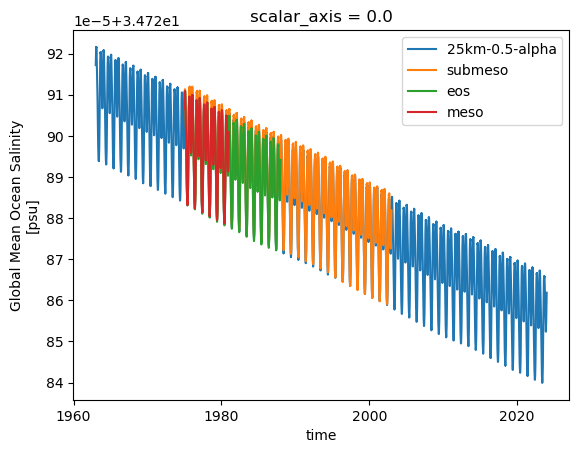

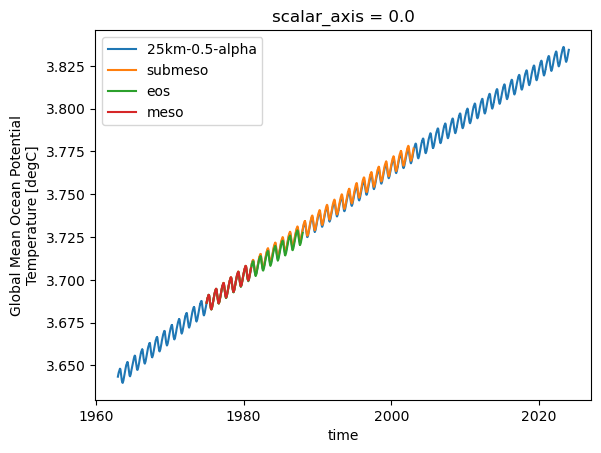

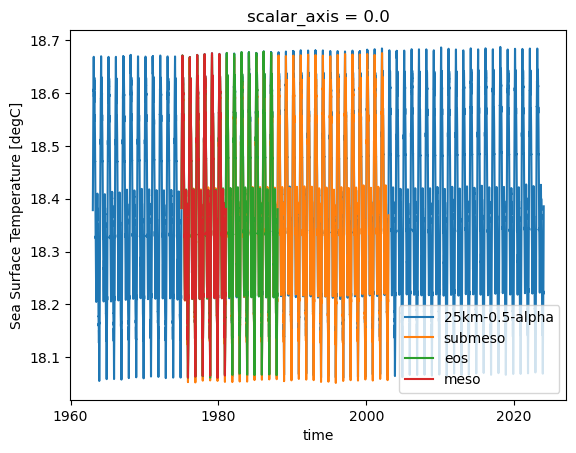

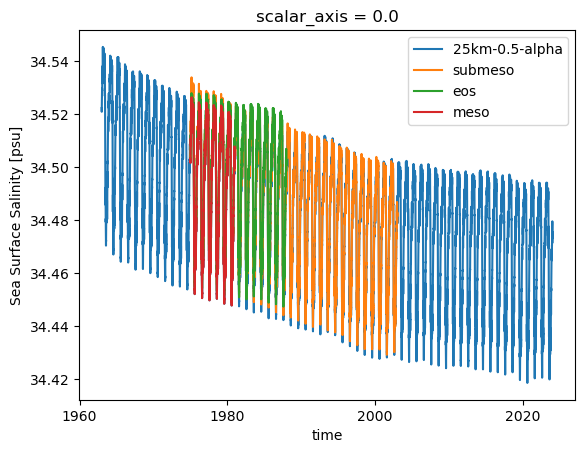

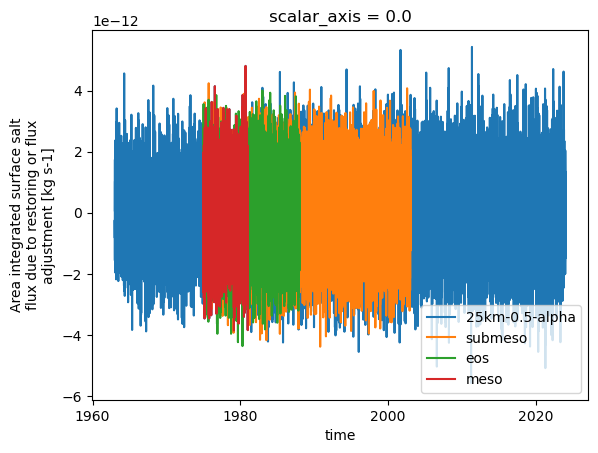

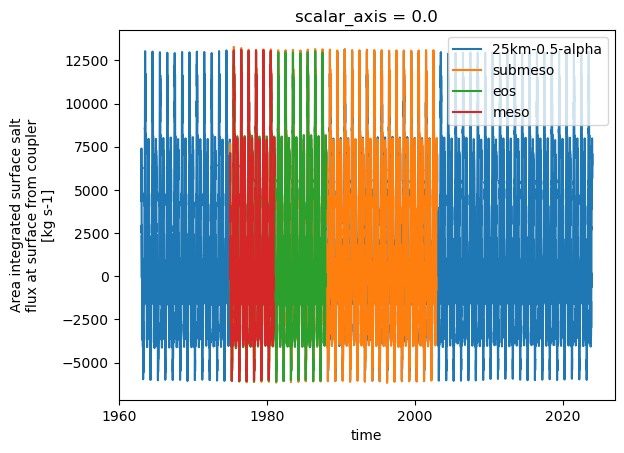

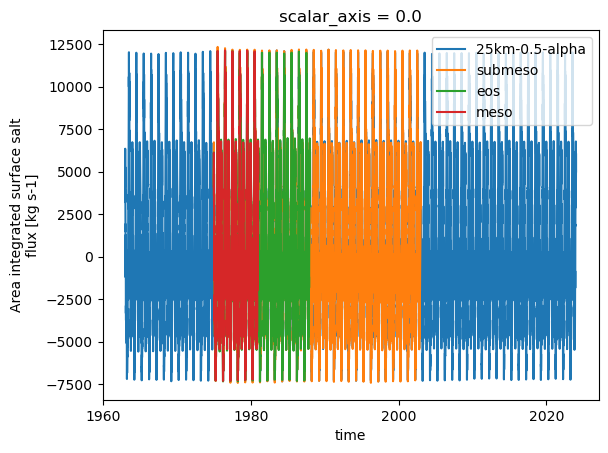

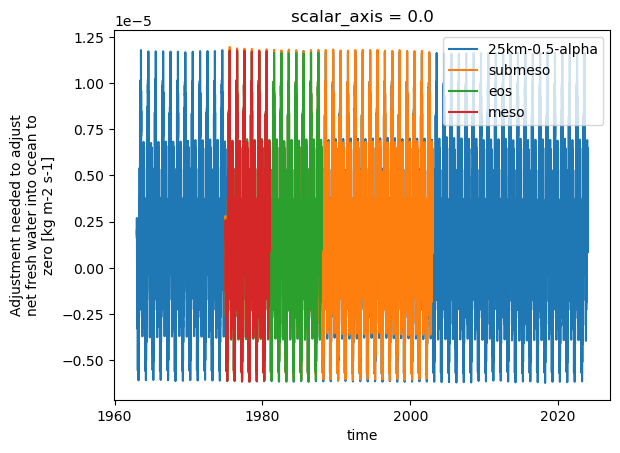

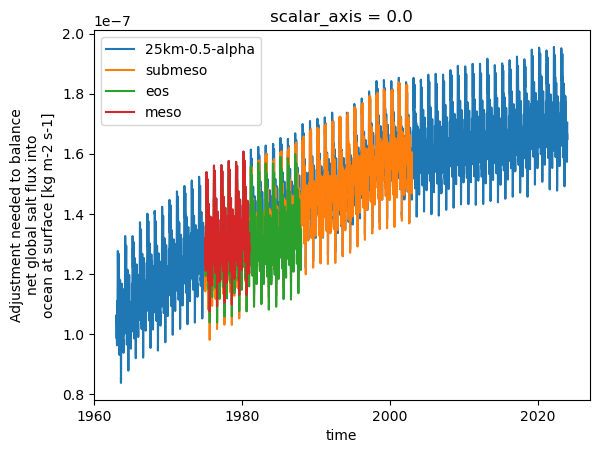

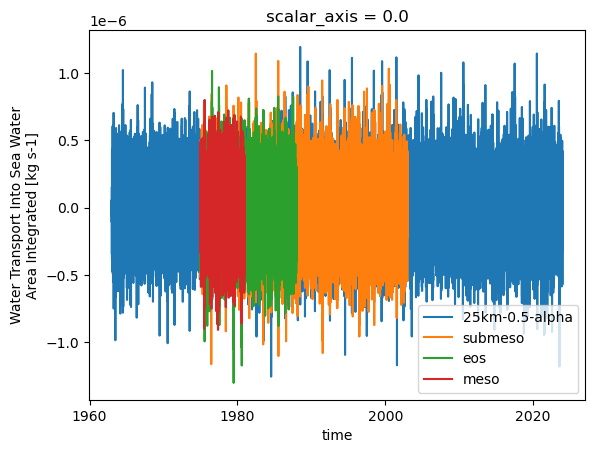

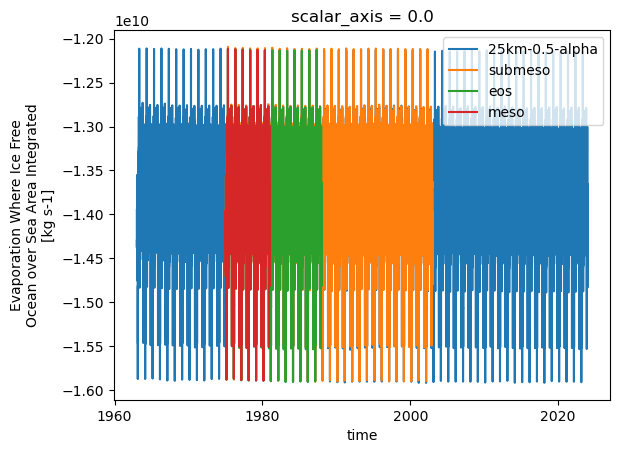

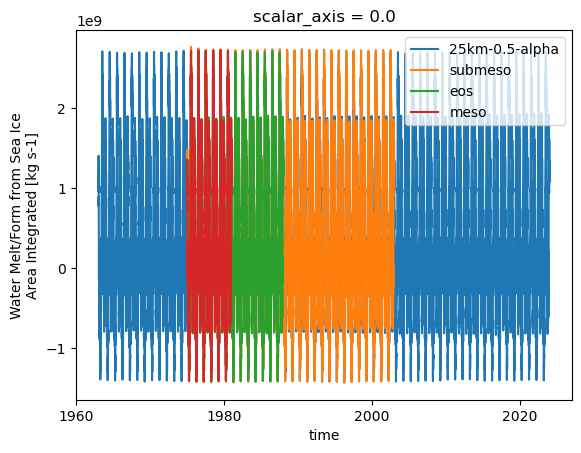

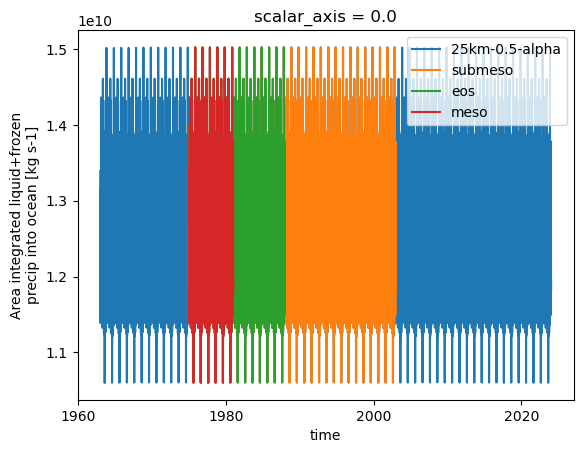

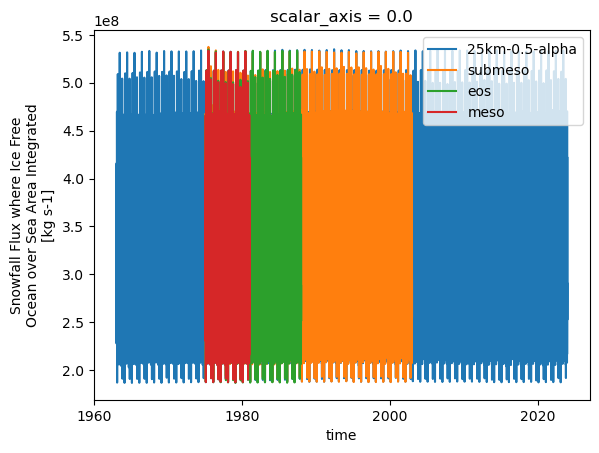

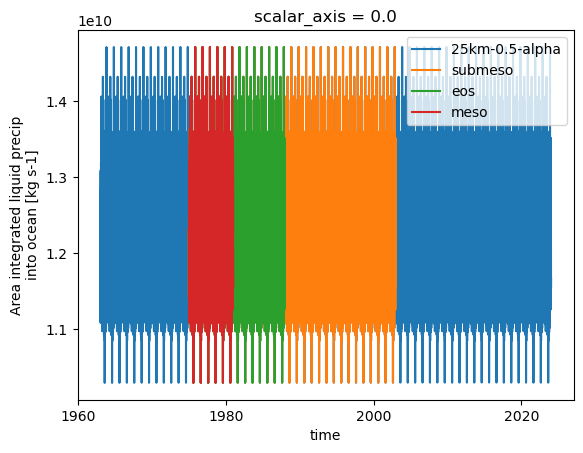

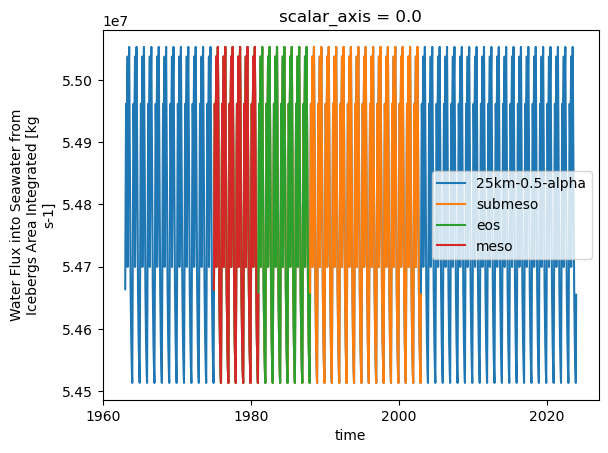

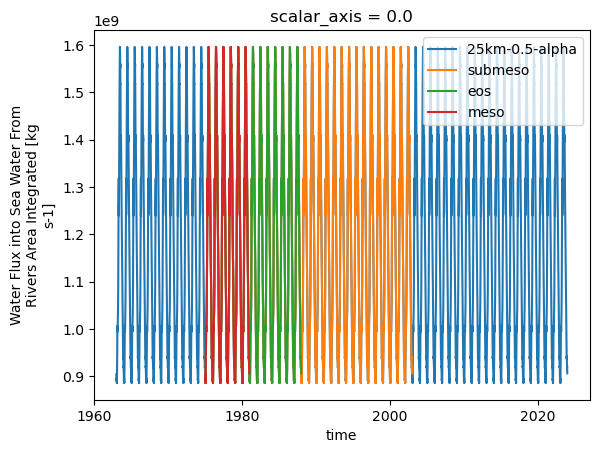

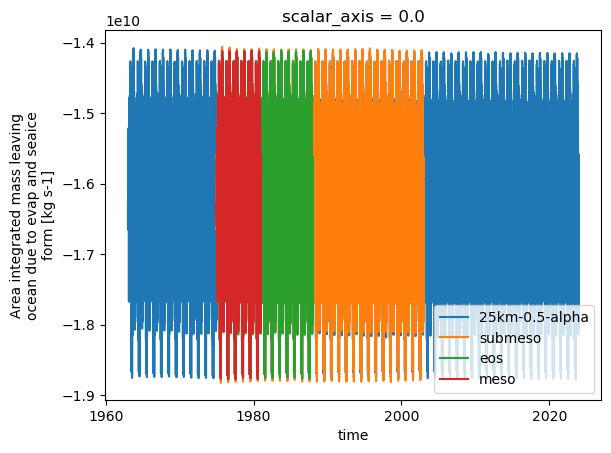

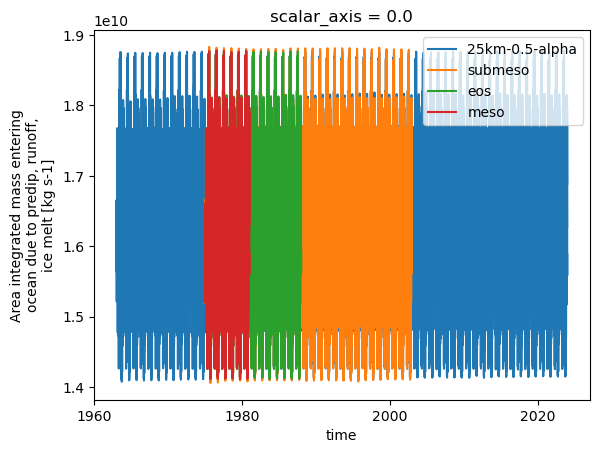

In [15]:
for iVar in mom_scalar_ds[list(EXPERIMENTS.keys())[0]].data_vars: #this is slightly lazy, we should intersect all the experiments to find the minimum subset of common scalar vars
    for iExp in EXPERIMENTS:
        mom_scalar_ds[iExp][iVar].plot(label=iExp)
    plt.legend()
    plt.show()

In [ ]:
client.close()